In [1]:
using DataFrames, DataFramesMeta, CSV
using NPZ
using Random, Statistics
using DSP,FFTW, AbstractFFTs,Interpolations
using Wavelets
using ContinuousWavelets
using HDF5

using PyPlot
plt.style.use("seaborn-whitegrid");
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 12
rcParams["figure.figsize"] = [16,12]
rcParams["figure.dpi"] = 220;

In [88]:
max_safe_exponent = 700.0

function fade(signal, fade_length=0.02)
    n = length(signal)
    n0 = floor(Int, length(signal) * fade_length)
    n01 = n0*4
    t = collect(1:n)
    res = deepcopy(signal)
    # @show(n, n0, n1, n-n1)
    res[1:n0] .= 0.0
    res[n-n0:n] .= 0.0
    for i in n0:n01
        res[i] = signal[i] * sin((i-n0)/(n01-n0) *0.5pi)
    end
    for i in n-n01:n-n0
        res[i] = signal[i] * sin(((n-n0) -i)/(n01-n0) *0.5pi)
    end
        
    return res
end

fade (generic function with 2 methods)

In [89]:
h = h5open("./Data/H-H1_LOSC_4_V1-1126259446-32.hdf5", "r") do file
        read(file, "strain/Strain")
    end;

h = fade(h)
sampling_rate = 4096.0  # Hz
dt = 1 / sampling_rate
t = collect(1:length(h)) / sampling_rate;
length(t)

131072

In [90]:
floor(Int, 2.1)

2

In [91]:
htilde = dt * rfft(h)
frequencies = AbstractFFTs.rfftfreq(length(h), sampling_rate);

In [92]:
function plot_td_and_fd(t, time_data, freq, freq_data)
    fig,(ax1, ax2) = plt.subplots(2,1)
    ax1.plot(t, time_data)
    ax1.set_xlabel("time[s]")
    ax1.set_ylabel("Detector strain h(dimensionless)")
    ax1.set_title("Time domain")
    ax2.plot(freq, abs.(freq_data))
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_xlim((1,2048*1.1))
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Detector strain of h̃ (Fourier transform)")
    ax2.set_title("Frequency domain") 
end

plot_td_and_fd (generic function with 1 method)

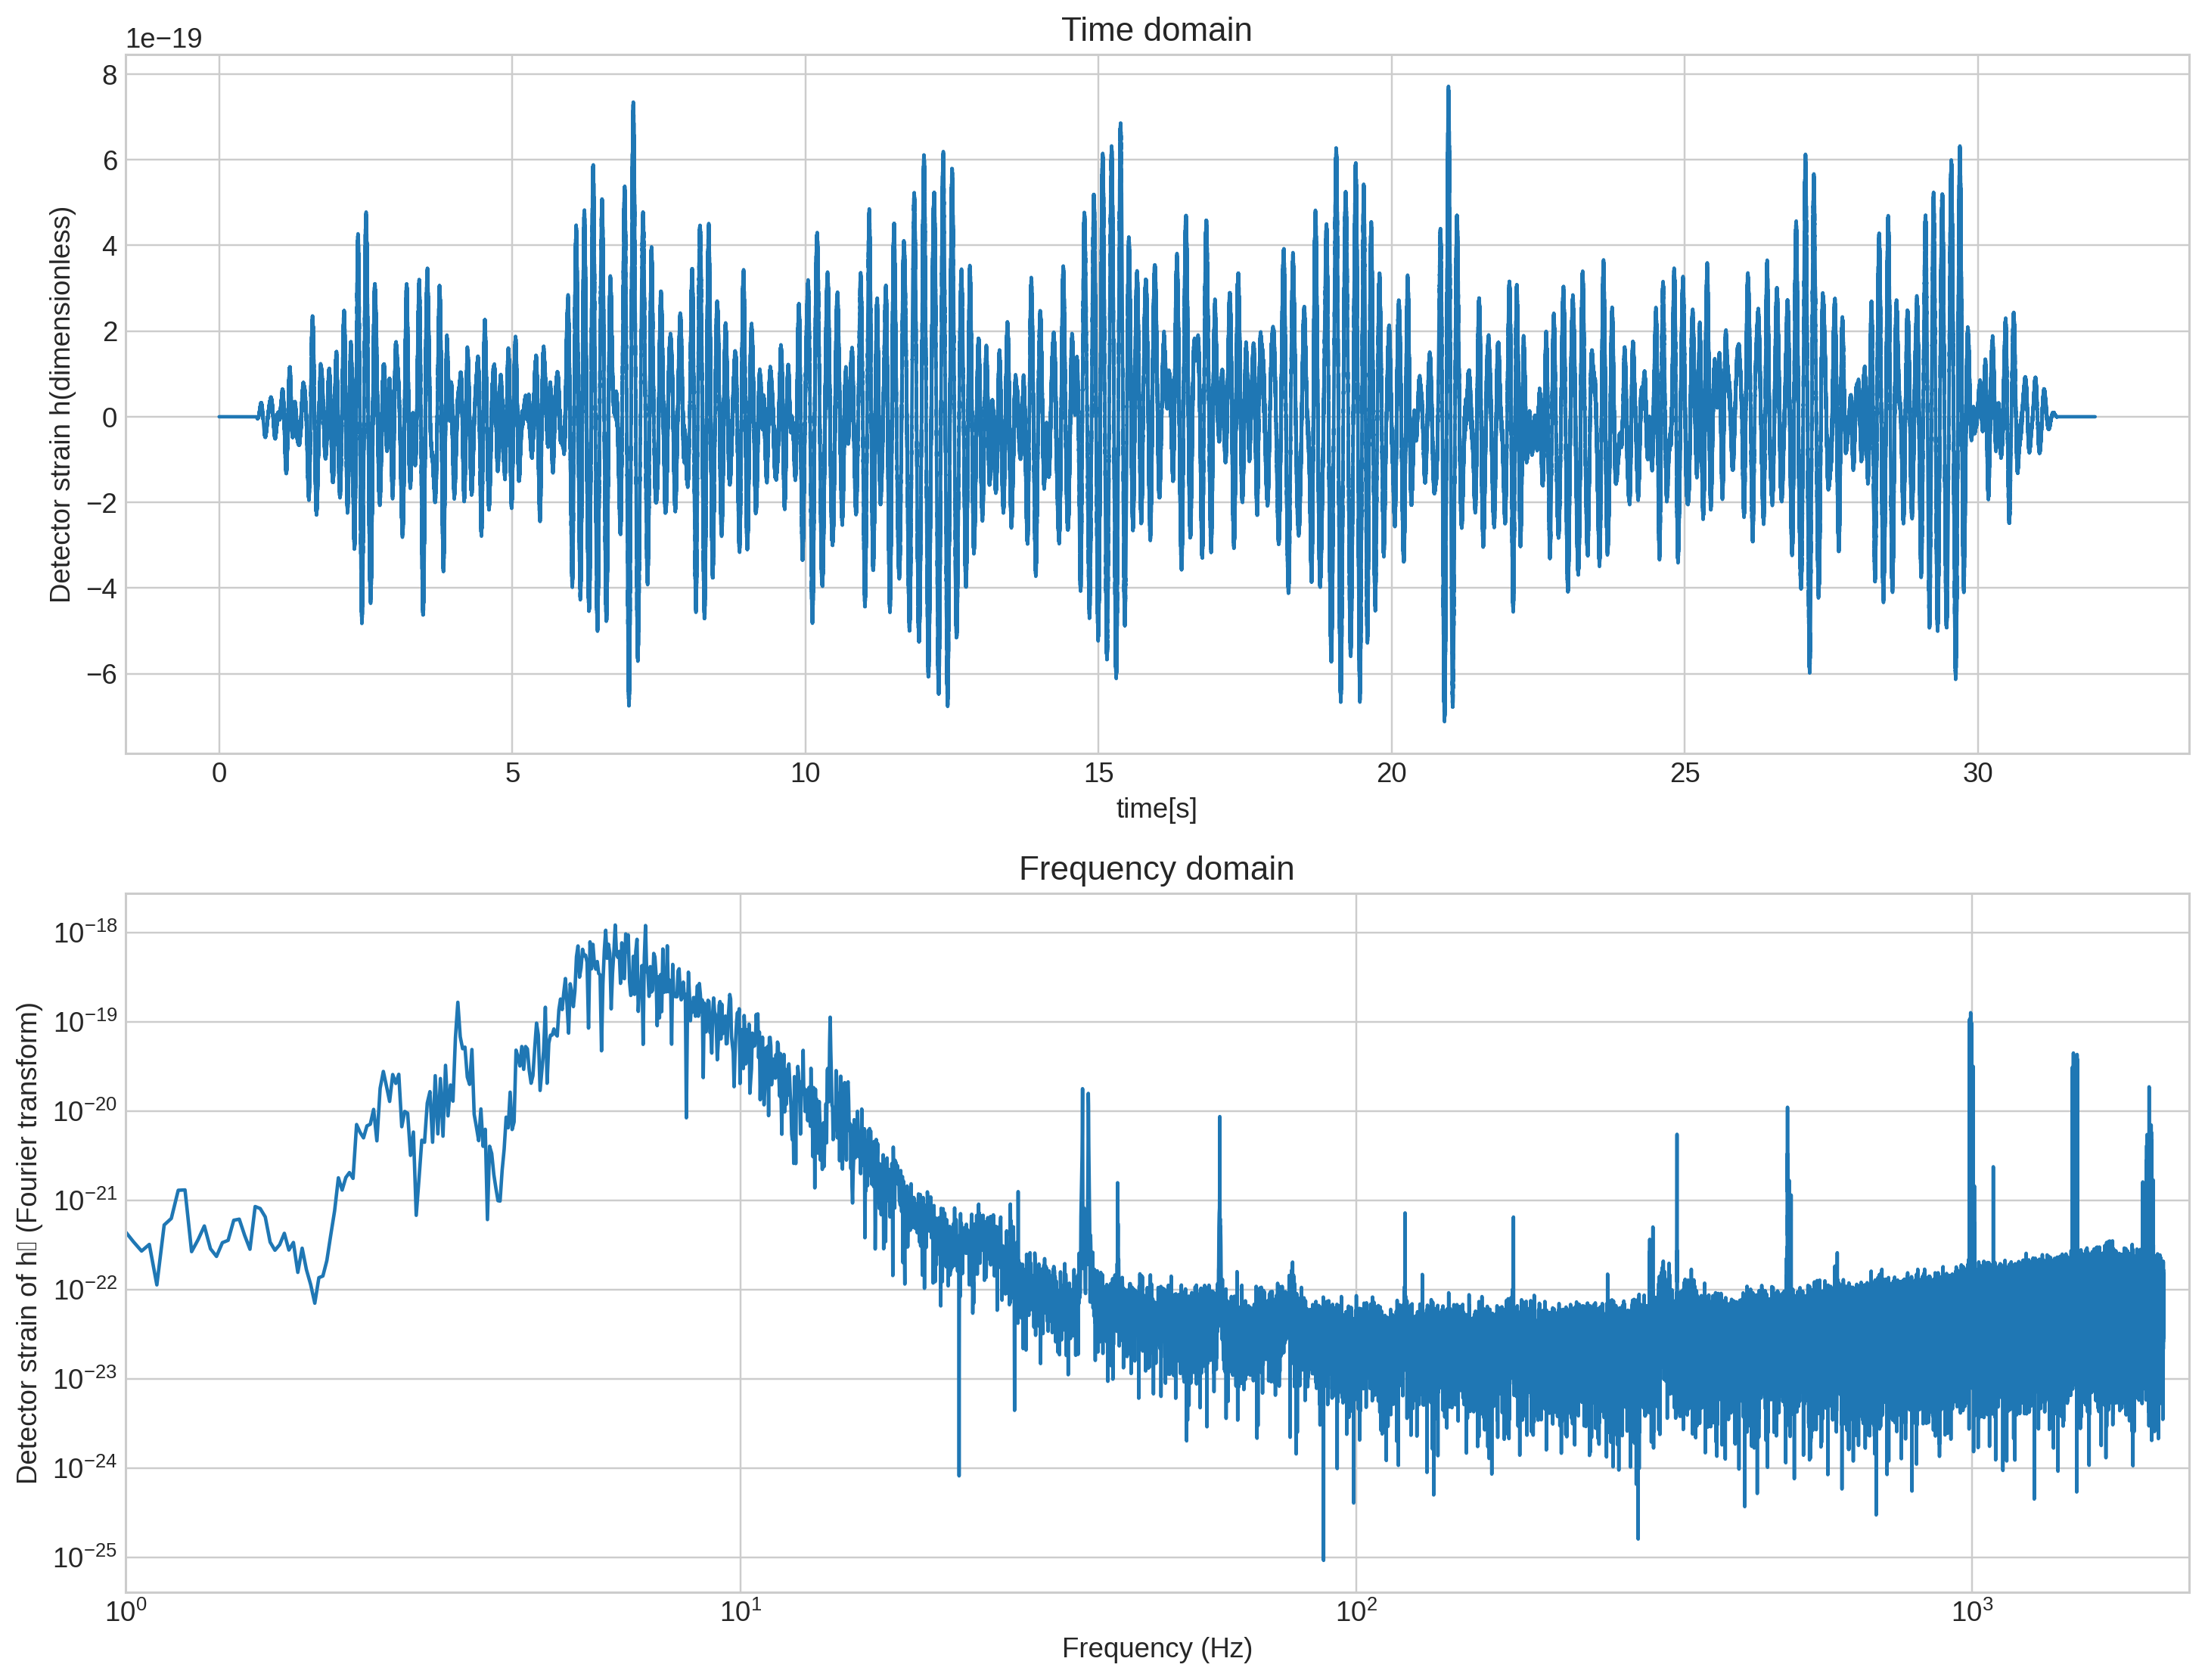

PyObject Text(0.5, 1.0, 'Frequency domain')

In [93]:
plot_td_and_fd(t, h, frequencies, htilde)

In [168]:
number_of_chunks = 8
points_per_chunk = 2^floor(Int, log2(length(h)/number_of_chunks))

function apply_welch(h, n_)
    s = welch_pgram(h,floor(Int, n_), div(n_, 2), fs=sampling_rate,window=hanning)
    f_noise, noise_welch = s.freq, s.power
    noise_spectral_density = sqrt.(2 * length(h) .* noise_welch ./ sampling_rate)
    nodes = (f_noise,)
    itp = interpolate(nodes, noise_spectral_density, Gridded(Linear()))
    noise_spectral_density_interpolator = itp(f_noise)
    return f_noise, noise_spectral_density
end

apply_welch (generic function with 1 method)

In [169]:
apply_welch(h, 2)

([0.0, 2048.0], [NaN, NaN])

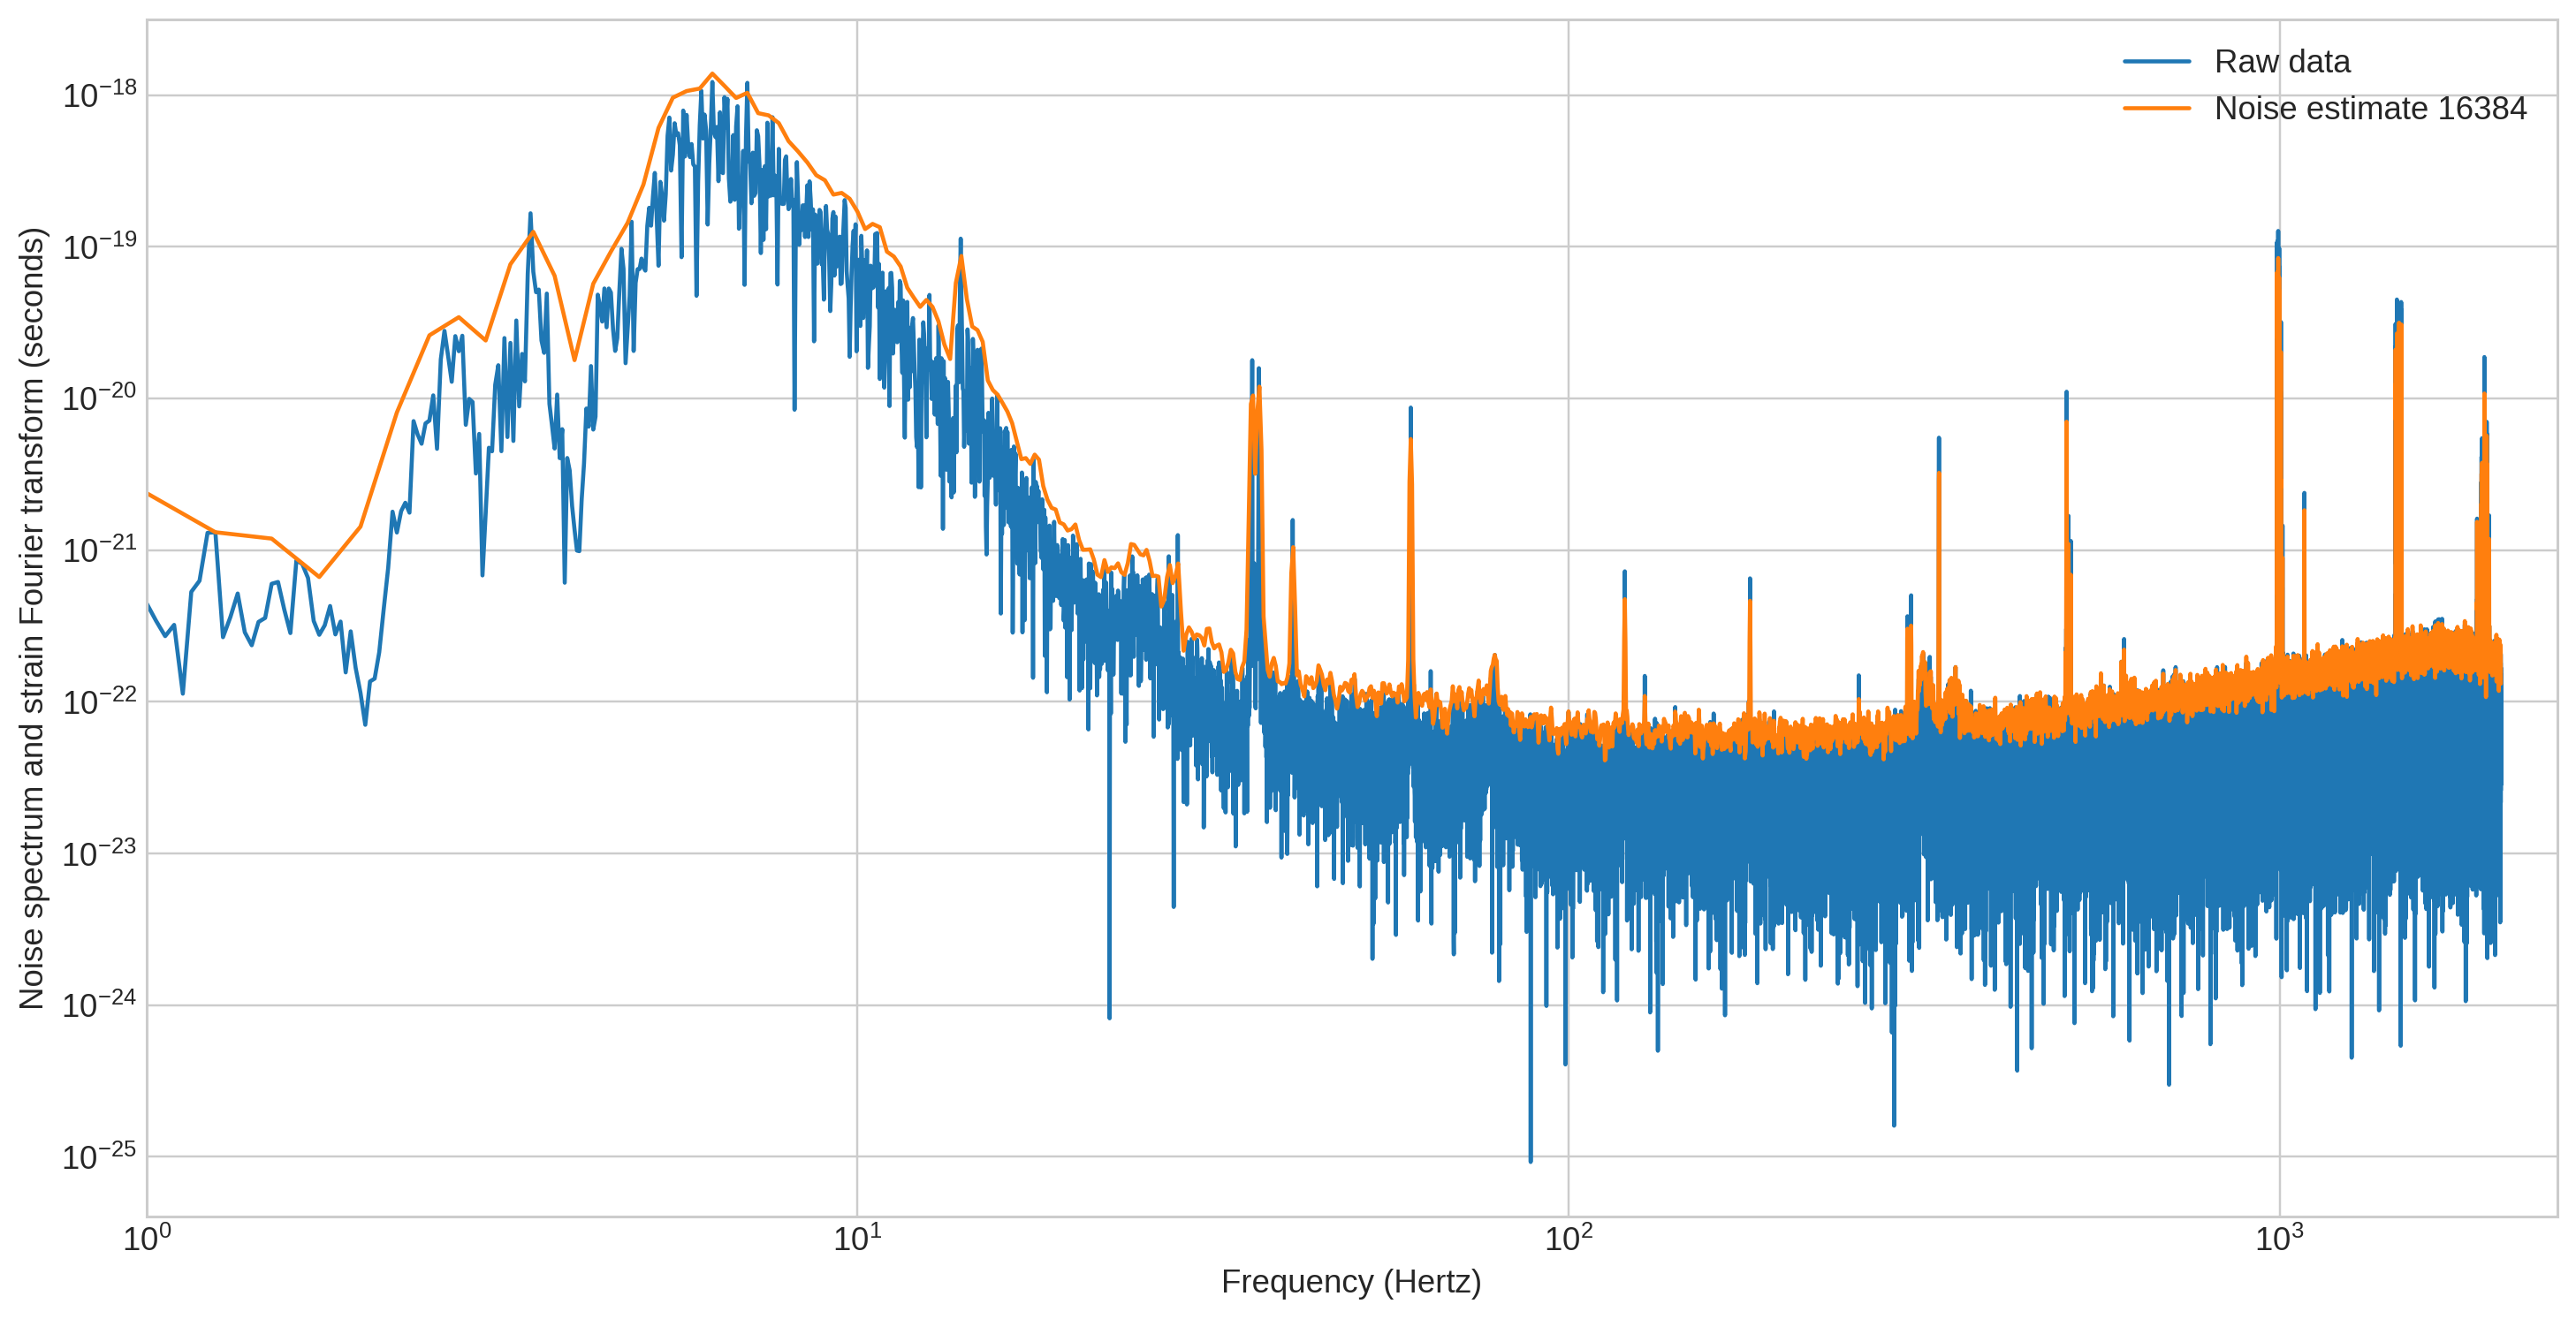

In [170]:
fig, ax = plt.subplots(figsize=(16,8))
ax.loglog(frequencies, abs.(htilde), label="Raw data")
for i in 15:20
    # x,y = apply_welch(h, 2^i)
    # ax.loglog(x, y, label="Noise estimate $(2^i)")
end
    x,y = apply_welch(h, points_per_chunk)
    ax.loglog(x, y, label="Noise estimate 16384")
    ax.set_xlim(1, 0.6*sampling_rate)
    ax.set_xlabel("Frequency (Hertz)")
ax.set_ylabel("Noise spectrum and strain Fourier transform (seconds)")
ax.legend();

In [158]:
frequencies

65537-element AbstractFFTs.Frequencies{Float64}:
    0.0
    0.03125
    0.0625
    0.09375
    0.125
    0.15625
    0.1875
    0.21875
    0.25
    0.28125
    0.3125
    0.34375
    0.375
    ⋮
 2047.65625
 2047.6875
 2047.71875
 2047.75
 2047.78125
 2047.8125
 2047.84375
 2047.875
 2047.90625
 2047.9375
 2047.96875
 2048.0

In [141]:
length(h)

131072